# Etapa 3 - Machine Learning

## Carla Rafaela Silva, pg42862; José Pereira, pg42871; Tiago Silva, pg42885.

Following the work done previously, we decided to use the molecule's descriptors and the RDK fingerprint, which we deemed to be the best. Each of these was used individualy as features in the machine learning task.
To amplify the study, we proposed to do a binary and multiclass classification, and also a regression.
The binary classification used the activity outcome as label. This label is divided between "Active" (1) and "Inactive" (0).
The multiclass classification derived from the 'Activity at 46.23 uM' column. We attributed the values a label corresponding to the interval it belong. Label 0: -150 <= value < -100; Label 1: -100 <= value < -50; Label 2: -50 <= value < 0; Label 3: 0 <= value 50.
Finnaly, the regression used the same column as the multiclass one, except it used the raw values.

All the datasets were divided. 70% for train set and 30% for test set.

## Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, matthews_corrcoef, ConfusionMatrixDisplay, precision_score, mean_squared_error, r2_score, explained_variance_score)
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor, VotingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import ClusterCentroids
from loaders.Loaders import CSVLoader
from featureImportance.shapValues import ShapValues
from utils.utils import draw_rdk_bits, draw_rdk_bit_on_molecule

%matplotlib inline

warnings.filterwarnings('ignore')

2022-01-15 15:45:34.956165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-01-15 15:45:34.956190: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Functions

In [2]:
def metrics(label_test, predict, reg=False):
    print('METRICS:')
    if reg is False:
        print(f"Accuracy score:\n{accuracy_score(label_test, predict)}\n")
        print(f"Recall score:\n{recall_score(label_test, predict, average='macro')}\n")
        print(f"Precison score:\n{precision_score(label_test, predict, average='macro', zero_division=0)}\n")
        print(f"F1-score:\n{f1_score(label_test, predict, average='macro')}\n")
        print(f"MCC score:\n{matthews_corrcoef(label_test, predict)}\n")
        print(f"Confusion matrix:\n{confusion_matrix(label_test, predict)}\n")
        print(f"Classification report:\n{classification_report(label_test, predict, zero_division=0, digits=3)}\n")
        ConfusionMatrixDisplay(confusion_matrix(label_test, predict)).plot(cmap=plt.cm.Blues)
    else:
        print(f"Explained variance score:\n{explained_variance_score(label_test, predict)}\n")
        print(f"R2 score:\n{r2_score(label_test, predict)}\n")
        print(f"Mean squared error:\n{mean_squared_error(label_test, predict)}\n")


The ***metrics*** function recieves the true labels for the test set and the labels predicted by the model and it computes all the relevant metrics as well as the confusion matrix.
It also has a optinal argument that indicates if we want to use regrerssion or not. In the case we want regression, the function will show metrics only for regression.

Classification scores:
**Accuracy score**: Fraction of the prediction the model got right. The best value is 1 and the worst value is 0.
**Recall score**: The recall is the ability of the classifier to find all the positive samples. The best value is 1 and the worst value is 0.
**Precison score**: The precision is the ability of the classifier not to label as positive a sample that is negative. The best value is 1 and the worst value is 0.
**F1-score**: The F1 score can be interpreted as a harmonic mean of the precision and recall. The best value is 1 and the worst value is 0.
**MCC score**: Measure of the quality of binary and multiclass classifications. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.

Regression scores:
**Explained variance score**: Explains the dispersion of errors of a given dataset. Best possible score is 1.0, lower values are worse.
**R2 score**: Proportion of the variance in the dependent variable that is predictable from the independent variable. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).
**Mean squared error**: Measure of how close a fitted line is to the datapoints. Best possible score is 0.0, higher values are worse.

In [3]:
def ml(model, data_train, data_test, label_train, label_test, param=None, reg=False, sampling=False):
    if sampling is True:
        data_train, label_train = ClusterCentroids(n_jobs=4).fit_resample(data_train, label_train)
        data_test, label_test = ClusterCentroids(n_jobs=4).fit_resample(data_test, label_test)

    # k-fold
    kfold = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    # Cross validation
    if reg is False:
        scores_scoring = cross_val_score(model, X=data_train, y=label_train, cv=kfold, scoring='accuracy')
        print(f'Cross Validation Accuracy score: {np.mean(scores_scoring)}\n')
    else:
        scores_scoring = cross_val_score(model, X=data_train, y=label_train, cv=5, scoring='explained_variance')
        print(f'Cross Validation Explained_variance score: {np.mean(scores_scoring)}\n')

    # model training - FIT
    model.fit(data_train, label_train)

    # PREDICT
    predict = model.predict(X=data_test)
    if reg is False:
        base_model = accuracy_score(label_test, predict)
        print('Base Model Accuracy: {:.3f}\n'.format(base_model))
    else:
        base_model = explained_variance_score(label_test, predict)
        print('Base Model Explained variance: {:.3f}\n'.format(base_model))

    if param != None:
        ## OPTIMIZATION
        if reg is False:
            search = HalvingGridSearchCV(estimator=model, param_grid=param, cv=kfold, scoring='accuracy', random_state=None,
                                         n_jobs=4)
        else:
            search = HalvingGridSearchCV(estimator=model, param_grid=param, cv=5, scoring='explained_variance', random_state=None,
                                         n_jobs=4)
        search.fit(X=data_train, y=label_train)

        # OPTI MODEL FITTED
        best_model = search.best_estimator_
        predict_opt = best_model.predict(X=data_test)
        if reg is False:
            opt_model = accuracy_score(label_test, predict_opt)
            print('Optimized Model Accuracy: {:.3f}\n'.format(opt_model))
        else:
            opt_model = explained_variance_score(label_test, predict_opt)
            print('Optimized Model Explained variance: {:.3f}\n'.format(opt_model))

        improv = ((opt_model-base_model)/base_model*100)
        print('Optimized model improved {:.3f}% over base model.\n'.format(improv))

        if improv >= 0:
            predict = predict_opt

    # Metrics
    metrics(label_test, predict, reg=reg)

The ***ml*** function will firstly do a cross validation to evaluate the model adaptation to the data. Secondly, it will fit the model and then predict the test set labels and it's corresponding accuracy. Lastly, it will do a hyperparameter optimization and then use the best parameters to predict the test set labels and it's accuracy.

# Models

In [4]:
rf = RandomForestClassifier(n_jobs=4)
nb = GaussianNB()
knn = KNeighborsClassifier(n_jobs=4)
voting = VotingClassifier(estimators=[('Random Forest', rf), ('Naive Bayes', nb), ('KNN', knn)], voting='soft', n_jobs=4)
nn = MLPClassifier(early_stopping=True)

These models were used only to classification task.
We used **Random Forest**, **Gaussian Naive Bayes**, **K Nearest Neighbors**, **Voting** which used all of the previous models, and **Neural Network** (Multi-Layer Perceptron).

# Hyperparameters

In [5]:
params_rf = {'n_estimators': range(50, 251, 25), 'criterion': ['entropy', 'gini'], 'max_features': ['sqrt', 'log2', 'auto'],
          'bootstrap': [True, False]}
params_knn = {'n_neighbors': range(2, 17, 2), 'weights': ['distance', 'uniform'], 'leaf_size': range(10, 50, 10), 'p': [1, 2]}
params_nn = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive']}

We only optimized the hyperparameters for the random forest, k nearest neighbors, and neural network models.

# Binary Classification

### Load data

In [6]:
descriptors = pd.read_csv('../dataset/binary_class/descriptors_fs.csv', sep=',')
fingerprint = pd.read_csv('../dataset/binary_class/rdk_fs.csv', sep=',')

descriptors_data_b = descriptors.drop("activity", axis=1)
descriptors_label_b = descriptors["activity"]
fingerprint_data_b = fingerprint.drop("activity", axis=1)
fingerprint_label_b = fingerprint["activity"]

In [7]:
descriptors.groupby('activity').size()

activity
0    19998
1    19991
dtype: int64

In [8]:
fingerprint.groupby('activity').size()

activity
0    19998
1    19992
dtype: int64

As we can see, the binary labels are balanced.

## Descriptors

In [9]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(descriptors_data_b, descriptors_label_b, test_size=0.3)

### Random Forest

Cross Validation Accuracy score: 0.8144827194107354

Base Model Accuracy: 0.822

Optimized Model Accuracy: 0.829

Optimized model improved 0.770% over base model.

METRICS:
Accuracy score:
0.8287071767941986

Recall score:
0.8286989639164151

Precison score:
0.8287256772173441

F1-score:
0.8287016734632805

MCC score:
0.657424640591035

Confusion matrix:
[[5005 1006]
 [1049 4937]]

Classification report:
              precision    recall  f1-score   support

           0      0.827     0.833     0.830      6011
           1      0.831     0.825     0.828      5986

    accuracy                          0.829     11997
   macro avg      0.829     0.829     0.829     11997
weighted avg      0.829     0.829     0.829     11997




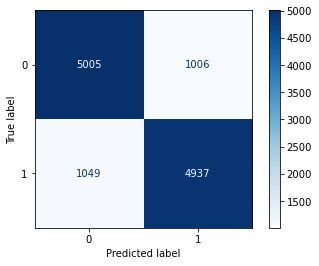

In [10]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf)

### Gaussian Naive Bayes

Cross Validation Accuracy score: 0.6994853748509804

Base Model Accuracy: 0.695

METRICS:
Accuracy score:
0.6947570225889805

Recall score:
0.6947060192520417

Precison score:
0.6951885191778875

F1-score:
0.6945517584463263

MCC score:
0.38989423987962313

Confusion matrix:
[[4323 1688]
 [1974 4012]]

Classification report:
              precision    recall  f1-score   support

           0      0.687     0.719     0.702      6011
           1      0.704     0.670     0.687      5986

    accuracy                          0.695     11997
   macro avg      0.695     0.695     0.695     11997
weighted avg      0.695     0.695     0.695     11997




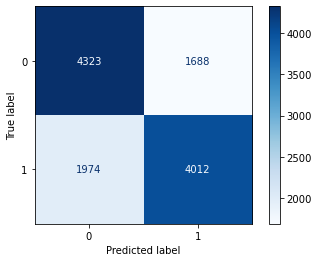

In [11]:
ml(nb, data_train, data_test, label_train, label_test, param=None)

### K Nearest Neighbors

Cross Validation Accuracy score: 0.7952630557656489

Base Model Accuracy: 0.795

Optimized Model Accuracy: 0.805

Optimized model improved 1.290% over base model.

METRICS:
Accuracy score:
0.8048678836375761

Recall score:
0.8048039836533123

Precison score:
0.8060017685889473

F1-score:
0.8046635681050573

MCC score:
0.6108045778180453

Confusion matrix:
[[5022  989]
 [1352 4634]]

Classification report:
              precision    recall  f1-score   support

           0      0.788     0.835     0.811      6011
           1      0.824     0.774     0.798      5986

    accuracy                          0.805     11997
   macro avg      0.806     0.805     0.805     11997
weighted avg      0.806     0.805     0.805     11997




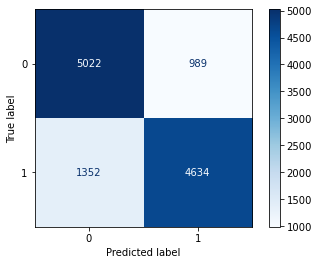

In [12]:
ml(knn, data_train, data_test, label_train, label_test, param=params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation Accuracy score: 0.769541248529745

Base Model Accuracy: 0.771

METRICS:
Accuracy score:
0.7710260898557972

Recall score:
0.7709481470183603

Precison score:
0.7725183721532325

F1-score:
0.7706771152826666

MCC score:
0.543464250759434

Confusion matrix:
[[4859 1152]
 [1595 4391]]

Classification report:
              precision    recall  f1-score   support

           0      0.753     0.808     0.780      6011
           1      0.792     0.734     0.762      5986

    accuracy                          0.771     11997
   macro avg      0.773     0.771     0.771     11997
weighted avg      0.772     0.771     0.771     11997




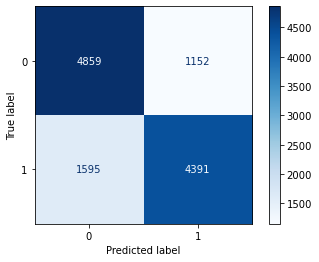

In [13]:
ml(voting, data_train, data_test, label_train, label_test, param=None)

### Neural Network

Cross Validation Accuracy score: 0.8010506201631857

Base Model Accuracy: 0.804

Optimized Model Accuracy: 0.803

Optimized model improved -0.187% over base model.

METRICS:
Accuracy score:
0.8043677586063183

Recall score:
0.8043413753702353

Precison score:
0.804555382686476

F1-score:
0.804327538678759

MCC score:
0.6088967204484204

Confusion matrix:
[[4911 1100]
 [1247 4739]]

Classification report:
              precision    recall  f1-score   support

           0      0.797     0.817     0.807      6011
           1      0.812     0.792     0.802      5986

    accuracy                          0.804     11997
   macro avg      0.805     0.804     0.804     11997
weighted avg      0.805     0.804     0.804     11997




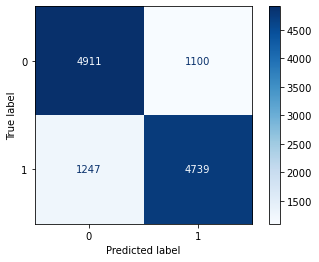

In [14]:
ml(nn, data_train, data_test, label_train, label_test, param=params_nn)

### Model comparison using descriptors

| Model | Accuracy | Recall | Precision | F1-score | MCC |
| :-: | :-: | :-: | :-: | :-: | :-: |
| **RF** | **0.829** | **0.829** | **0.829** | **0.829** | **0.657** |
| **NB** | 0.695 | 0.695 | 0.695 | 0.695 | 0.390 |
| **KNN** | 0.805 | 0.805 | 0.806 | 0.805 | 0.611 |
| **Voting** | 0.771 | 0.771 | 0.773 | 0.771 | 0.543 |
| **NN** | 0.804 | 0.804 | 0.805 | 0.804 | 0.610 |

Following the results, we concluded that the best model to classify the molecule's activity using the descriptors would be **Random Forest**.
Tracing back, it is noteworthy that the optimized neural network model did not improve over the default model. This could be explained with the low depth of optimization, but we were also limited by computational resources. The other two models improved with optimization. Random forest improved 0.770% over the default model. K nearest neighbors improved 1.290% over the default model.


## Descriptors without feature selection

We only used random forest to compare both datasets, firstly because it was the best model, and secondly because we did not had the computational power to do all models.

In [15]:
descriptors = pd.read_csv('../dataset/binary_class/descriptors_binary.csv', sep=',')

descriptors_data_b = descriptors.drop("activity", axis=1)
descriptors_data_b = StandardScaler().fit_transform(descriptors_data_b)
descriptors_label_b = descriptors["activity"]

### Random Forest

Cross Validation Accuracy score: 0.8155545626767807

Base Model Accuracy: 0.820

Optimized Model Accuracy: 0.830

Optimized model improved 1.179% over base model.

METRICS:
Accuracy score:
0.8301241977160957

Recall score:
0.8301116485240918

Precison score:
0.8301696775935594

F1-score:
0.830113988833747

MCC score:
0.660281323567698

Confusion matrix:
[[5026  985]
 [1053 4933]]

Classification report:
              precision    recall  f1-score   support

           0      0.827     0.836     0.831      6011
           1      0.834     0.824     0.829      5986

    accuracy                          0.830     11997
   macro avg      0.830     0.830     0.830     11997
weighted avg      0.830     0.830     0.830     11997




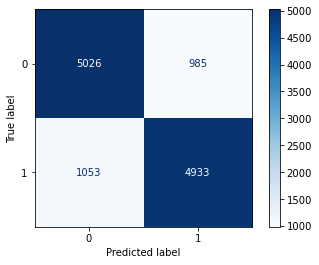

In [16]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf)

### Comparison between feature selection and all features

| Model | Accuracy | Recall | Precision | F1-score | MCC |
| :-: | :-: | :-: | :-: | :-: | :-: |
| **RF_FS** | 0.829 | 0.829 | 0.829 | 0.829 | 0.657 |
| **RF_noFS** | **0.830** | **0.830** | **0.830** | **0.830** | **0.660** |

Compairing the results using the dataset with feature selection and the dataset without feature selection, it is noteworthy that the model performed a small margin better on the dataset without feature selection. This could be explained by the low number of features, as the dataset without feature selection has only **208** features. Even though, the dataset with feature selection performed worse, we deemed it feasible to be used in this case since the difference is negligible.

## Fingerprints

In [17]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_b, fingerprint_label_b, test_size=0.3)

### Random Forest

Cross Validation Accuracy score: 0.8070947633237984

Base Model Accuracy: 0.812

Optimized Model Accuracy: 0.815

Optimized model improved 0.339% over base model.

METRICS:
Accuracy score:
0.8151204467783613

Recall score:
0.8150400586309279

Precison score:
0.8153943633090053

F1-score:
0.815049481491927

MCC score:
0.6304343223801608

Confusion matrix:
[[5007 1023]
 [1195 4772]]

Classification report:
              precision    recall  f1-score   support

           0      0.807     0.830     0.819      6030
           1      0.823     0.800     0.811      5967

    accuracy                          0.815     11997
   macro avg      0.815     0.815     0.815     11997
weighted avg      0.815     0.815     0.815     11997




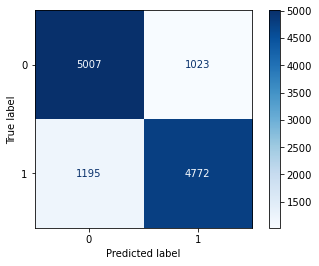

In [18]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf)

### Gaussian Naive Bayes

Cross Validation Accuracy score: 0.6613794021427676

Base Model Accuracy: 0.668

METRICS:
Accuracy score:
0.6680836875885638

Recall score:
0.6681043000182596

Precison score:
0.6681058885229207

F1-score:
0.668083629935371

MCC score:
0.3362101885374278

Confusion matrix:
[[4005 2025]
 [1957 4010]]

Classification report:
              precision    recall  f1-score   support

           0      0.672     0.664     0.668      6030
           1      0.664     0.672     0.668      5967

    accuracy                          0.668     11997
   macro avg      0.668     0.668     0.668     11997
weighted avg      0.668     0.668     0.668     11997




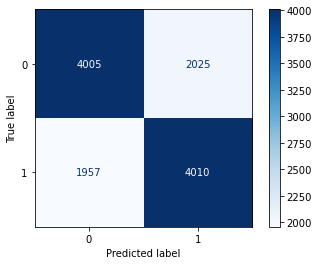

In [19]:
ml(nb, data_train, data_test, label_train, label_test, param=None)

### K Nearest Neighbors

Cross Validation Accuracy score: 0.7740506282670163

Base Model Accuracy: 0.787

Optimized Model Accuracy: 0.800

Optimized model improved 1.673% over base model.

METRICS:
Accuracy score:
0.8002834041843794

Recall score:
0.7999408437951019

Precison score:
0.8053847383671575

F1-score:
0.7993158892587884

MCC score:
0.6053011022887425

Confusion matrix:
[[5217  813]
 [1583 4384]]

Classification report:
              precision    recall  f1-score   support

           0      0.767     0.865     0.813      6030
           1      0.844     0.735     0.785      5967

    accuracy                          0.800     11997
   macro avg      0.805     0.800     0.799     11997
weighted avg      0.805     0.800     0.799     11997




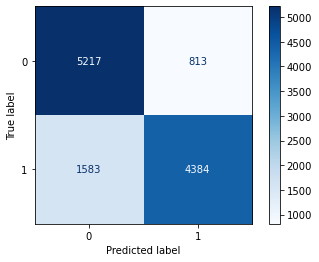

In [20]:
ml(knn, data_train, data_test, label_train, label_test, param=params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation Accuracy score: 0.7505089492771032

Base Model Accuracy: 0.764

METRICS:
Accuracy score:
0.7636909227306826

Recall score:
0.7635745355675119

Precison score:
0.7641531453953402

F1-score:
0.7635289313181025

MCC score:
0.5277273637638064

Confusion matrix:
[[4738 1292]
 [1543 4424]]

Classification report:
              precision    recall  f1-score   support

           0      0.754     0.786     0.770      6030
           1      0.774     0.741     0.757      5967

    accuracy                          0.764     11997
   macro avg      0.764     0.764     0.764     11997
weighted avg      0.764     0.764     0.764     11997




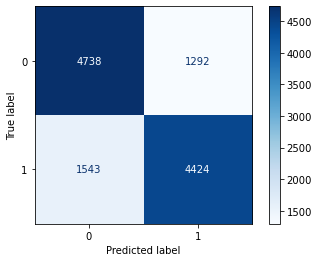

In [21]:
ml(voting, data_train, data_test, label_train, label_test, param=None)

### Neural Network

Cross Validation Accuracy score: 0.7743363808203132

Base Model Accuracy: 0.781

Optimized Model Accuracy: 0.778

Optimized model improved -0.427% over base model.

METRICS:
Accuracy score:
0.780861882137201

Recall score:
0.7808335146789931

Precison score:
0.7808789005624875

F1-score:
0.7808420932429059

MCC score:
0.5617124134079103

Confusion matrix:
[[4741 1289]
 [1340 4627]]

Classification report:
              precision    recall  f1-score   support

           0      0.780     0.786     0.783      6030
           1      0.782     0.775     0.779      5967

    accuracy                          0.781     11997
   macro avg      0.781     0.781     0.781     11997
weighted avg      0.781     0.781     0.781     11997




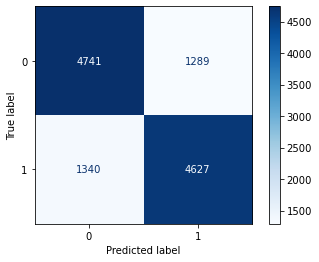

In [22]:
ml(nn, data_train, data_test, label_train, label_test, param=params_nn)

### Model comparison using fingerprints

| Model | Accuracy | Recall | Precision | F1-score | MCC |
| :-: | :-: | :-: | :-: | :-: | :-: |
| **RF** | **0.815** | **0.815** | **0.815** | **0.815** | **0.630** |
| **NB** | 0.668 | 0.668 | 0.668 | 0.668 | 0.336 |
| **KNN** | 0.800 | 0.800 | 0.805 | 0.799 | 0.605 |
| **Voting** | 0.764 | 0.764 | 0.764 | 0.764 | 0.528 |
| **NN** | 0.781 | 0.781 | 0.781 | 0.781 | 0.562 |

Following the results, we concluded that the best model to classify the molecule's activity using the fingerprints would be **Random Forest**.
Tracing back, it is noteworthy that the optimized neural network model did not improve over the default model. The other two models improved with optimization. Random forest improved 0.339% over the base model. K nearest neighbors improved 1.673% over the base model.

## Comparison between descriptors and fingerprints

| Features | Model | Accuracy | Recall | Precision | F1-score | MCC |
|:-: | :-: | :-: | :-: | :-: | :-: | :-: |
| **Descriptors** | RF | **0.829** | **0.829** | **0.829** | **0.829** | **0.657** |
| **Fingerprints** | RF | 0.815 | 0.815 | 0.815 | 0.815 | 0.630 |

Comparing the results from both feature's type, we concluded that the **descriptors** would be better to classify the molecule's activity.

# Multiclass

### Load data

In [23]:
descriptors = pd.read_csv('../dataset/multiclass/descriptors_fs.csv', sep=',')
fingerprint = pd.read_csv('../dataset/multiclass/rdk_fs.csv', sep=',')

descriptors_data_m = descriptors.drop("Activity at 46.23 uM", axis=1)
descriptors_label_m = descriptors["Activity at 46.23 uM"]
fingerprint_data_m = fingerprint.drop("Activity at 46.23 uM", axis=1)
fingerprint_label_m = fingerprint["Activity at 46.23 uM"]

In [24]:
descriptors.groupby("Activity at 46.23 uM").size()

Activity at 46.23 uM
0     5295
1    14613
2    14687
3     5346
dtype: int64

In [25]:
fingerprint.groupby("Activity at 46.23 uM").size()

Activity at 46.23 uM
0     5295
1    14613
2    14687
3     5346
dtype: int64

As we can see, the multiclass labels can be divided into two balanced groups: label 0 and 3, and label 1 and 2. The labels from the former group have nearly three times less molecules then the later group. This imbalance could be an issue with the classification.

## Descriptors

In [26]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(descriptors_data_m, descriptors_label_m, test_size=0.3)

### Random Forest Classifier

Cross Validation Accuracy score: 0.5687462529832203

Base Model Accuracy: 0.567

Optimized Model Accuracy: 0.572

Optimized model improved 0.898% over base model.

METRICS:
Accuracy score:
0.572060418926813

Recall score:
0.4122046165424656

Precison score:
0.46646544489702635

F1-score:
0.38585287225675485

MCC score:
0.3530885861910202

Confusion matrix:
[[ 123 1159  293    7]
 [ 177 3286  879   12]
 [  14  854 3355  187]
 [   1  194 1351   91]]

Classification report:
              precision    recall  f1-score   support

           0      0.390     0.078     0.130      1582
           1      0.598     0.755     0.667      4354
           2      0.571     0.761     0.652      4410
           3      0.306     0.056     0.094      1637

    accuracy                          0.572     11983
   macro avg      0.466     0.412     0.386     11983
weighted avg      0.521     0.572     0.513     11983




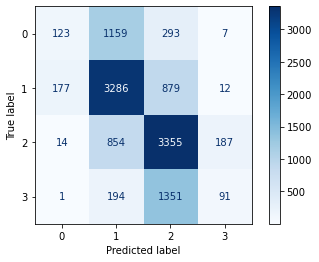

In [27]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf)

### Gaussian Naive Bayes

Cross Validation Accuracy score: 0.4006725823153857

Base Model Accuracy: 0.399

METRICS:
Accuracy score:
0.39881498789952435

Recall score:
0.37175794785809474

Precison score:
0.35886169934493384

F1-score:
0.347745128014939

MCC score:
0.15987078547308173

Confusion matrix:
[[ 221  821  327  213]
 [ 461 2486  959  448]
 [ 133 1291 1274 1712]
 [  46  361  432  798]]

Classification report:
              precision    recall  f1-score   support

           0      0.257     0.140     0.181      1582
           1      0.501     0.571     0.534      4354
           2      0.426     0.289     0.344      4410
           3      0.252     0.487     0.332      1637

    accuracy                          0.399     11983
   macro avg      0.359     0.372     0.348     11983
weighted avg      0.407     0.399     0.390     11983




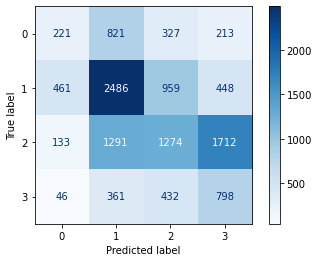

In [28]:
ml(nb, data_train, data_test, label_train, label_test, param=None)

### K Nearest Neighbors Classifier

Cross Validation Accuracy score: 0.5117672958968135

Base Model Accuracy: 0.517

Optimized Model Accuracy: 0.549

Optimized model improved 6.064% over base model.

METRICS:
Accuracy score:
0.5488608862555286

Recall score:
0.39603626886329496

Precison score:
0.43712977646058787

F1-score:
0.37123371958857765

MCC score:
0.3163167059913649

Confusion matrix:
[[ 125 1111  332   14]
 [ 223 3106 1000   25]
 [  38  959 3260  153]
 [  15  217 1319   86]]

Classification report:
              precision    recall  f1-score   support

           0      0.312     0.079     0.126      1582
           1      0.576     0.713     0.637      4354
           2      0.552     0.739     0.632      4410
           3      0.309     0.053     0.090      1637

    accuracy                          0.549     11983
   macro avg      0.437     0.396     0.371     11983
weighted avg      0.496     0.549     0.493     11983




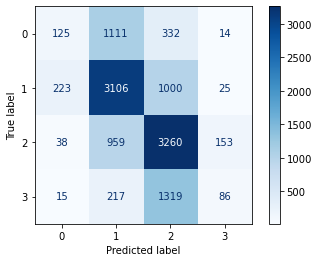

In [29]:
ml(knn, data_train, data_test, label_train, label_test, param=params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation Accuracy score: 0.5008587465190966

Base Model Accuracy: 0.502

METRICS:
Accuracy score:
0.5023783693565885

Recall score:
0.40563315692366686

Precison score:
0.43063615760547547

F1-score:
0.4026663602493231

MCC score:
0.2670684963331119

Confusion matrix:
[[ 195  981  310   96]
 [ 266 2959  927  202]
 [  64 1023 2424  899]
 [  22  244  929  442]]

Classification report:
              precision    recall  f1-score   support

           0      0.356     0.123     0.183      1582
           1      0.568     0.680     0.619      4354
           2      0.528     0.550     0.539      4410
           3      0.270     0.270     0.270      1637

    accuracy                          0.502     11983
   macro avg      0.431     0.406     0.403     11983
weighted avg      0.485     0.502     0.484     11983




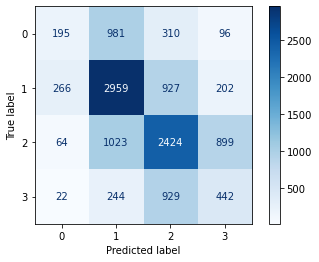

In [30]:
ml(voting, data_train, data_test, label_train, label_test, param=None)

### Neural Network Classifier

Cross Validation Accuracy score: 0.554761247703173

Base Model Accuracy: 0.562

Optimized Model Accuracy: 0.556

Optimized model improved -1.010% over base model.

METRICS:
Accuracy score:
0.5617958774931152

Recall score:
0.387772252526833

Precison score:
0.4827514636482493

F1-score:
0.3355853490127585

MCC score:
0.33353411400130756

Confusion matrix:
[[  31 1171  379    1]
 [  36 3190 1126    2]
 [   6  892 3504    8]
 [   2  226 1402    7]]

Classification report:
              precision    recall  f1-score   support

           0      0.413     0.020     0.037      1582
           1      0.582     0.733     0.649      4354
           2      0.547     0.795     0.648      4410
           3      0.389     0.004     0.008      1637

    accuracy                          0.562     11983
   macro avg      0.483     0.388     0.336     11983
weighted avg      0.520     0.562     0.480     11983




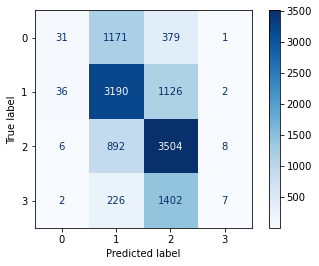

In [31]:
ml(nn, data_train, data_test, label_train, label_test, param=params_nn)

### Undersampling

Sampling is method that aims to balance the dataset. Undersampling keeps all of the data in the minority class and decreases the size of the majority class.

Cross Validation Accuracy score: 0.45780412934008136

Base Model Accuracy: 0.511

Optimized Model Accuracy: 0.532

Optimized model improved 4.147% over base model.

METRICS:
Accuracy score:
0.531763590391909

Recall score:
0.531763590391909

Precison score:
0.533860817915566

F1-score:
0.5322884098601687

MCC score:
0.37591752422120855

Confusion matrix:
[[820 485 141 136]
 [384 829 262 107]
 [112 261 791 418]
 [108  97 452 925]]

Classification report:
              precision    recall  f1-score   support

           0      0.576     0.518     0.546      1582
           1      0.496     0.524     0.510      1582
           2      0.481     0.500     0.490      1582
           3      0.583     0.585     0.584      1582

    accuracy                          0.532      6328
   macro avg      0.534     0.532     0.532      6328
weighted avg      0.534     0.532     0.532      6328




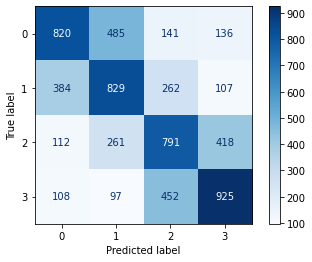

In [32]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf, sampling=True)

### Model comparison using descriptors

| Model | Accuracy | Recall | Precision | F1-score | MCC |
| :-: | :-: | :-: | :-: | :-: | :-: |
| **RF** | **0.572** | 0.412 | 0.466 | 0.386 | 0.353 |
| **NB** | 0.399 | 0.371 | 0.359 | 0.348 | 0.160 |
| **KNN** | 0.549 | 0.396 | 0.437 | 0.371 | 0.316 |
| **Voting** | 0.502 | 0.406 | 0.431 | 0.403 | 0.267 |
| **NN** | 0.562 | 0.388 | 0.483 | 0.336 | 0.334 |
| **Sampling_RF** | 0.532 | **0.532** | **0.534** | **0.532** | **0.376** |

Following the results, we concluded that the best model to classify the interval of the molecule's activity at 46.23 uM using the descriptors would be **Random Forest** using the **undersampling** method.
Tracing back, it is noteworthy that the optimized neural network model did not improve over the default model. The other models improved with optimization. Random forest improved 0.898% over the default model. K nearest neighbors improved 6.064% over the default modelThe optimized random forest model using the unsersampling technique improved 4.147% over the default model.

Overall, the sampling method helps the prediction in this unbalaced classes. With the sampling method, the model is more capable of correctly predicting all 4 labels, even though it is still not effective in this task.

## Fingerprints

In [33]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_m, fingerprint_label_m, test_size=0.3)

### Random Forest Classifier

Cross Validation Accuracy score: 0.5472492642861292

Base Model Accuracy: 0.550

Optimized Model Accuracy: 0.554

Optimized model improved 0.561% over base model.

METRICS:
Accuracy score:
0.5535341734123341

Recall score:
0.42186430284742255

Precison score:
0.4525196222365191

F1-score:
0.41644188008349675

MCC score:
0.33074540505285555

Confusion matrix:
[[ 244 1069  279   11]
 [ 402 3039  912   35]
 [  55  766 3148  427]
 [  13  210 1171  202]]

Classification report:
              precision    recall  f1-score   support

           0      0.342     0.152     0.211      1603
           1      0.598     0.693     0.642      4388
           2      0.571     0.716     0.636      4396
           3      0.299     0.127     0.178      1596

    accuracy                          0.554     11983
   macro avg      0.453     0.422     0.416     11983
weighted avg      0.514     0.554     0.520     11983




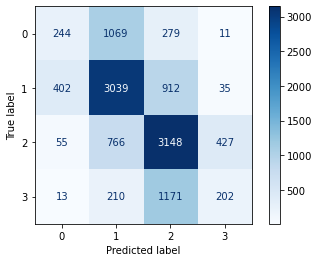

In [34]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf)

### Gaussian Naive Bayes

Cross Validation Accuracy score: 0.34251371315385526

Base Model Accuracy: 0.336

METRICS:
Accuracy score:
0.3361428690645081

Recall score:
0.3495667513990663

Precison score:
0.32846121278089263

F1-score:
0.31837384259085444

MCC score:
0.11375013899591954

Confusion matrix:
[[ 453  608  286  256]
 [1105 1743  818  722]
 [ 500 1033 1076 1787]
 [ 174  311  355  756]]

Classification report:
              precision    recall  f1-score   support

           0      0.203     0.283     0.236      1603
           1      0.472     0.397     0.431      4388
           2      0.424     0.245     0.310      4396
           3      0.215     0.474     0.295      1596

    accuracy                          0.336     11983
   macro avg      0.328     0.350     0.318     11983
weighted avg      0.384     0.336     0.343     11983




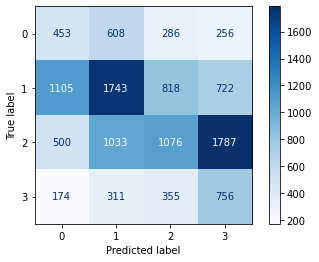

In [35]:
ml(nb, data_train, data_test, label_train, label_test, param=None)

### K Nearest Neighbors Classifier

Cross Validation Accuracy score: 0.5125185991485908

Base Model Accuracy: 0.513

Optimized Model Accuracy: 0.542

Optimized model improved 5.577% over base model.

METRICS:
Accuracy score:
0.5418509555203205

Recall score:
0.4094041145093918

Precison score:
0.4423059538466376

F1-score:
0.40163822172051244

MCC score:
0.3139365044645507

Confusion matrix:
[[ 210  993  381   19]
 [ 380 2731 1221   56]
 [  59  609 3361  367]
 [  14  154 1237  191]]

Classification report:
              precision    recall  f1-score   support

           0      0.317     0.131     0.185      1603
           1      0.609     0.622     0.615      4388
           2      0.542     0.765     0.634      4396
           3      0.302     0.120     0.171      1596

    accuracy                          0.542     11983
   macro avg      0.442     0.409     0.402     11983
weighted avg      0.504     0.542     0.506     11983




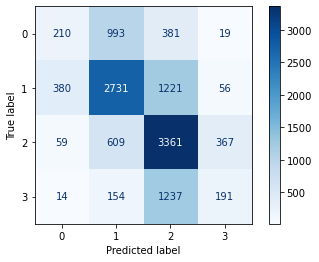

In [36]:
ml(knn, data_train, data_test, label_train, label_test, param=params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation Accuracy score: 0.4727089815048659

Base Model Accuracy: 0.471

METRICS:
Accuracy score:
0.4713343903863807

Recall score:
0.3998829843126428

Precison score:
0.4025794327796145

F1-score:
0.3978979307183515

MCC score:
0.24181648797049088

Confusion matrix:
[[ 300  887  272  144]
 [ 552 2575  881  380]
 [ 197  789 2285 1125]
 [  61  220  827  488]]

Classification report:
              precision    recall  f1-score   support

           0      0.270     0.187     0.221      1603
           1      0.576     0.587     0.581      4388
           2      0.536     0.520     0.528      4396
           3      0.228     0.306     0.261      1596

    accuracy                          0.471     11983
   macro avg      0.403     0.400     0.398     11983
weighted avg      0.474     0.471     0.471     11983




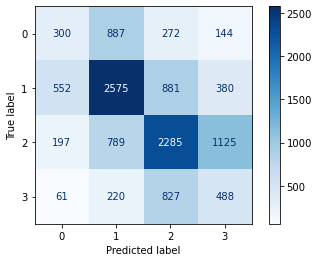

In [37]:
ml(voting, data_train, data_test, label_train, label_test, param=None)

### Neural Network Classifier

Cross Validation Accuracy score: 0.5333716958764457

Base Model Accuracy: 0.540

Optimized Model Accuracy: 0.537

Optimized model improved -0.571% over base model.

METRICS:
Accuracy score:
0.540348827505633

Recall score:
0.3862762081920815

Precison score:
0.4525811163919515

F1-score:
0.35839310832801013

MCC score:
0.29976206637643743

Confusion matrix:
[[  66 1162  361   14]
 [  76 3178 1098   36]
 [  20 1062 3119  195]
 [   4  306 1174  112]]

Classification report:
              precision    recall  f1-score   support

           0      0.398     0.041     0.075      1603
           1      0.557     0.724     0.630      4388
           2      0.542     0.710     0.615      4396
           3      0.314     0.070     0.115      1596

    accuracy                          0.540     11983
   macro avg      0.453     0.386     0.358     11983
weighted avg      0.498     0.540     0.481     11983




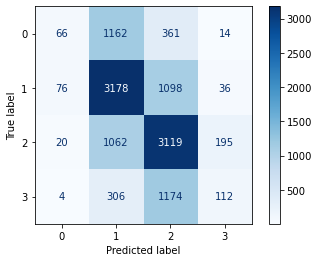

In [38]:
ml(nn, data_train, data_test, label_train, label_test, param=params_nn)

### Model comparison using fingerprints

| Model | Accuracy | Recall | Precision | F1-score | MCC |
| :-: | :-: | :-: | :-: | :-: | :-: |
| **RF** | **0.554** | **0.422** | 0.453 | **0.416** | **0.331** |
| **NB** | 0.336 | 0.350 | 0.328 | 0.318 | 0.114 |
| **KNN** | 0.542 | 0.409 | 0.442 | 0.402 | 0.314 |
| **Voting** | 0.471 | 0.400 | 0.403 | 0.398 | 0.242 |
| **NN** | 0.540 | 0.386 | **0.453** | 0.358 | 0.300 |

Following the results, we concluded that the best model to classify the interval of the molecule's activity at 46.23 uM using the fingerprints would be **Random Forest**.
Tracing back, it is noteworthy that the neural network model did not improve with optimization. The other modeld improved with optimization. Random forest improved 0.561% over the default model. K nearest neighbors improved 5.577% over the default model.

## Comparison between descriptors and fingerprints

| Features | Model | Accuracy | Recall | Precision | F1-score | MCC |
|:-: | :-: | :-: | :-: | :-: | :-: | :-: |
| **Descriptors** | RF | **0.572** | 0.412 | **0.466** | 0.386 | **0.353** |
| **Fingerprints** | RF | 0.554 | **0.422** | 0.453 | **0.416** | 0.331 |

Comparing the results from both feature's type, we concluded that the **descriptors** would be better to classify the interval of the molecule's activity at 46.23 uM just by a small margin.

# Regression

### Load data

In [4]:
descriptors = pd.read_csv('../dataset/regression/descriptors_fs.csv', sep=',')
fingerprint = pd.read_csv('../dataset/regression/rdk_fs.csv', sep=',')

descriptors_data_r = descriptors.drop("Activity at 46.23 uM", axis=1)
descriptors_label_r = descriptors["Activity at 46.23 uM"]
fingerprint_data_r = fingerprint.drop("Activity at 46.23 uM", axis=1)
fingerprint_label_r = fingerprint["Activity at 46.23 uM"]

### Models

The models used previously could not be applied to regression. We used the regresiion version of the same models with the exception of the Gaussian Naive Bayes. We used Linear Regression instead.

In [5]:
rf = RandomForestRegressor(n_jobs=4)
lr = LinearRegression(n_jobs=4)
knn = KNeighborsRegressor(n_jobs=4)
voting = VotingRegressor(estimators=[('Random Forest', rf), ('Linear Regression', lr), ('KNN', knn)], n_jobs=4)
nn = MLPRegressor(early_stopping=True)

### Hyperparameters

In [6]:
params_rf = {'n_estimators': range(50, 251, 25), 'criterion': ['squared_error', 'absolute_error'], 'max_features': ['sqrt', 'log2', 'auto'],
          'bootstrap': [True, False]}
params_knn = {'n_neighbors': range(2, 17, 2), 'weights': ['distance', 'uniform'], 'leaf_size': range(10, 50, 10), 'p': [1, 2]}
params_nn = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive']}

## Descriptors

In [7]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(descriptors_data_r, descriptors_label_r, test_size=0.3)

### Random Forest Regressor

In [8]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf, reg=True)

Cross Validation Explained_variance score: 0.4588372910406228

Base Model Explained variance: 0.473

Optimized Model Explained variance: 0.509

Optimized model improved 7.634% over base model.

METRICS:
Explained variance score:
0.5091043208875254

R2 score:
0.5088937012572958

Mean squared error:
914.1765909898854



### Linear Regression

In [44]:
ml(lr, data_train, data_test, label_train, label_test, param=None, reg=True)

Cross Validation Explained_variance score: 0.31468276216666025

Base Model Explained variance: 0.303

METRICS:
Explained variance score:
0.30317605884309295

R2 score:
0.3031494324606383

Mean squared error:
1289.8297997297748



### K Nearest Neighbors Regressor

In [45]:
ml(knn, data_train, data_test, label_train, label_test, param=params_knn, reg=True)

Cross Validation Explained_variance score: 0.4033563559026378

Base Model Explained variance: 0.434

Optimized Model Explained variance: 0.486

Optimized model improved 11.955% over base model.

METRICS:
Explained variance score:
0.4862161272871336

R2 score:
0.4846593862594941

Mean squared error:
953.8654506096678



### Voting Regressor

In [46]:
ml(voting, data_train, data_test, label_train, label_test, param=None, reg=True)

Cross Validation Explained_variance score: -5.461353193824156e+21

Base Model Explained variance: 0.468

METRICS:
Explained variance score:
0.4680810419637156

R2 score:
0.46784098130911067

Mean squared error:
984.9953382777322



### Neural Network Regressor

In [47]:
ml(nn, data_train, data_test, label_train, label_test, param=params_nn, reg=True)

Cross Validation Explained_variance score: 0.4077551023172276

Base Model Explained variance: 0.398

Optimized Model Explained variance: 0.397

Optimized model improved -0.367% over base model.

METRICS:
Explained variance score:
0.3980188731045762

R2 score:
0.39801742063755163

Mean squared error:
1114.23468093254



### Model comparison using descriptors

| Model | Explained variance | R squared | Mean squared error |
| :-: | :-: | :-: | :-: |
| **RF** | **0.509** | **0.509** | **914.177** |
| **LR** | 0.303 | 0.303 | 1289.830 |
| **KNN** | 0.486 | 0.485 | 953.865 |
| **Voting** | 0.468 | 0.468 | 984.995 |
| **NN** | 0.398 | 0.398 | 1114.235 |

Following the results, we concluded that the best model to predict the value of the molecule's activity at 46.23 uM using the descriptors would be **Random Forest**.
Tracing back, it is noteworthy that the optimized neural network model did not improve over the default model. The other two models improved with optimization. Random forest improved 7.634% over the default model. K nearest neighbors improved 11.955% over the default model. In this case, the optimization was successful in improving both models.

## Fingerprints

In [9]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_r, fingerprint_label_r, test_size=0.3)

### Random Forest Regressor

In [10]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf, reg=True)

Cross Validation Explained_variance score: 0.41560508051915734

Base Model Explained variance: 0.442

Optimized Model Explained variance: 0.452

Optimized model improved 2.227% over base model.

METRICS:
Explained variance score:
0.45211312979037543

R2 score:
0.45188607446353835

Mean squared error:
1013.1012559043622



### Linear Regression

In [50]:
ml(lr, data_train, data_test, label_train, label_test, param=None, reg=True)

Cross Validation Explained_variance score: 0.18550560469051397

Base Model Explained variance: 0.196

METRICS:
Explained variance score:
0.19610468499273215

R2 score:
0.19599286606687538

Mean squared error:
1479.7510971188356



### K Nearest Neighbors Regressor

In [51]:
ml(knn, data_train, data_test, label_train, label_test, param=params_knn, reg=True)

Cross Validation Explained_variance score: 0.35155037038016973

Base Model Explained variance: 0.378

Optimized Model Explained variance: 0.424

Optimized model improved 12.183% over base model.

METRICS:
Explained variance score:
0.4244185057453722

R2 score:
0.4170861374559838

Mean squared error:
1072.8355399108093



### Voting Regressor

In [52]:
ml(voting, data_train, data_test, label_train, label_test, param=None, reg=True)

Cross Validation Explained_variance score: 0.3957369455285372

Base Model Explained variance: 0.421

METRICS:
Explained variance score:
0.420675836150464

R2 score:
0.42013818214812737

Mean squared error:
1067.2183428847557



### Neural Network Regressor

In [53]:
ml(nn, data_train, data_test, label_train, label_test, param=params_nn, reg=True)

Cross Validation Explained_variance score: 0.34177448226821144

Base Model Explained variance: 0.353

Optimized Model Explained variance: 0.374

Optimized model improved 6.146% over base model.

METRICS:
Explained variance score:
0.3742736404687018

R2 score:
0.3739662834877343

Mean squared error:
1152.1963422273077



### Model comparison using fingerprints

| Model | Explained variance | R squared | Mean squared error |
| :-: | :-: | :-: | :-: |
| **RF** | **0.452** | **0.452** | **1013.101** |
| **LR** | 0.196 | 0.196 | 1479.751 |
| **KNN** | 0.424 | 0.417 | 1072.836 |
| **Voting** | 0.421 | 0.420 | 1067.218 |
| **NN** | 0.374 | 0.374 | 1152.196 |

Following the results, we concluded that the best model to predict the value of the molecule's activity at 46.23 uM using the fingerprints would be **Random Forest**.
Tracing back, it is noteworthy that all models improved with optimization. Random forest improved 2.227% over the default model. K nearest neighbors improved 12.183% over the default model. Neural network improved 6.146% over the default model. In this case, the optimization was successful in improving the models.


## Comparison between descriptors and fingerprints

| Features | Model | Explained variance | R squared | Mean squared error |
|:-: | :-: | :-: | :-: | :-: |
| **Descriptors** | RF | **0.509** | **0.509** | **914.177** |
| **Fingerprints** | RF | 0.452 | 0.452 | 1013.101 |

Comparing the results from both feature's type, we concluded that the **descriptors** would be better to predict the value of the molecule's activity at 46.23 uM.

# Conclusion

From all these analysis, we concluded that the best model overall was **Random Forest** and the best features to use was the descriptors.
It is noteworthy that these models provide a good performance when their task is binary classification. Otherwise, they do not perform as expected.
Concluding, we proved that it is possible and efficient to classify the molecule's activity using their descriptors or fingerprints.

# Feature Importance

In [2]:
rdk_path = '/home/laptop16/Desktop/Mestrado/2_ano/SIB/Grupo/CODE_SIB/src/smiles/dataset/binary_class/rdk_fs_all.csv'

bits = [0, 5, 25, 34, 36, 55, 77, 78, 101, 103, 105, 106, 113, 117, 128, 129, 142, 175, 188, 194, 195, 196, 197, 200,
        203, 211, 231, 270, 274, 278, 281, 291, 309, 335, 365, 382, 386, 388, 400, 406, 411, 419, 427, 438, 443, 461,
        471, 492, 498, 515, 516, 522, 532, 549, 563, 586, 589, 594, 608, 620, 632, 636, 640, 668, 671, 674, 676, 684,
        697, 701, 704, 707, 719, 728, 734, 738, 742, 759, 779, 791, 798, 799, 838, 841, 847, 853, 857, 865, 870, 876,
        883, 887, 927, 935, 940, 955, 962, 972, 985, 992, 1016, 1024, 1037, 1043, 1045, 1051, 1072, 1097, 1104, 1113,
        1123, 1130, 1133, 1134, 1145, 1155, 1180, 1184, 1222, 1238, 1255, 1265, 1287, 1288, 1295, 1302, 1305, 1338,
        1341, 1342, 1346, 1347, 1369, 1374, 1375, 1377, 1389, 1400, 1403, 1420, 1421, 1451, 1456, 1472, 1479, 1483,
        1492, 1494, 1500, 1501, 1520, 1522, 1528, 1533, 1536, 1542, 1545, 1548, 1556, 1579, 1599, 1605, 1612, 1652,
        1656, 1667, 1670, 1672, 1676, 1681, 1682, 1685, 1686, 1699, 1705, 1707, 1727, 1732, 1734, 1771, 1778, 1792,
        1818, 1820, 1823, 1832, 1846, 1849, 1861, 1867, 1872, 1876, 1885, 1889, 1892, 1915, 1921, 1931, 1942, 1971,
        1973, 1992, 1995, 2003, 2041]

str_bits = list(str(x) for x in bits)

In [3]:
loader = CSVLoader(rdk_path, mols_field='smiles', labels_fields='activity', features_fields=str_bits)

In [4]:
dataset = loader.create_dataset()
dataset.get_shape()

Mols_shape:  39990
Features_shape:  (39990, 205)
Labels_shape:  (39990,)


## Data

In [5]:
fingerprint = pd.read_csv('../dataset/binary_class/rdk_fs.csv', sep=',')
fingerprint_data_b = fingerprint.drop("activity", axis=1)
fingerprint_label_b = fingerprint["activity"]

In [6]:
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_b, fingerprint_label_b, test_size=0.3)

## Retrain ML Random Forest

In [7]:
model = RandomForestClassifier(n_jobs=-1)

In [8]:
# CV
kfold = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
# Cross validation
scores_scoring = cross_val_score(model, X=data_train, y=label_train, cv=kfold, scoring='accuracy')
print(f'Cross Validation Accuracy score: {np.mean(scores_scoring)}\n')

# FIT
model.fit(data_train, label_train)

# PREDICT
predict = model.predict(X=data_test)

base_model = accuracy_score(label_test, predict)
print('Base Model Accuracy: {:.3f}\n'.format(base_model))

Cross Validation Accuracy score: 0.8031291889067365

Base Model Accuracy: 0.809



## SHAP Values

### Compounds

In [9]:
mole_path = '/home/laptop16/Desktop/Mestrado/2_ano/SIB/Grupo/CODE_SIB/src/smiles/dataset/binary_class/shap_mole.csv'

bits = [0,5,25,34,36,55,77,78,101,103,105,106,113,117,128,129,142,175,188,194,195,196,197,200,203,211,231,270,274,278,281,291,309,335,365,382,386,388,400,406,411,419,427,438,443,461,471,492,498,515,516,522,532,549,563,586,589,594,608,620,632,636,640,668,671,674,676,684,697,701,704,707,719,728,734,738,742,759,779,791,798,799,838,841,847,853,857,865,870,876,883,887,927,935,940,955,962,972,985,992,1016,1024,1037,1043,1045,1051,1072,1097,1104,1113,1123,1130,1133,1134,1145,1155,1180,1184,1222,1238,1255,1265,1287,1288,1295,1302,1305,1338,1341,1342,1346,1347,1369,1374,1375,1377,1389,1400,1403,1420,1421,1451,1456,1472,1479,1483,1492,1494,1500,1501,1520,1522,1528,1533,1536,1542,1545,1548,1556,1579,1599,1605,1612,1652,1656,1667,1670,1672,1676,1681,1682,1685,1686,1699,1705,1707,1727,1732,1734,1771,1778,1792,1818,1820,1823,1832,1846,1849,1861,1867,1872,1876,1885,1889,1892,1915,1921,1931,1942,1971,1973,1992,1995,2003,2041]
str_bits = [str(x) for x in bits]

loader_mole = CSVLoader(mole_path, mols_field='smiles', labels_fields='activity', features_fields=str_bits)
mole = loader_mole.create_dataset()
mole.get_shape()

Mols_shape:  61
Features_shape:  (61, 205)
Labels_shape:  (61,)


Permutation explainer: 62it [00:14,  1.69it/s]                        


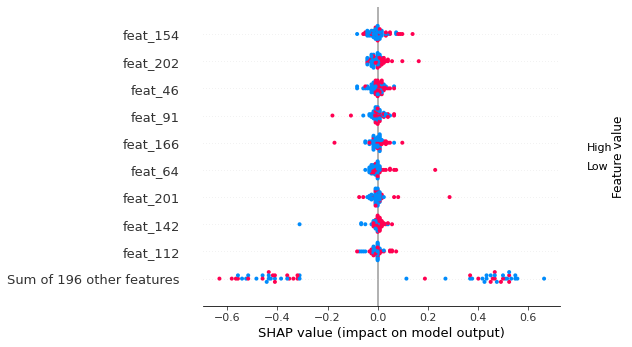

In [11]:
shap_calc = ShapValues(mole, model)
shap_calc.computePermutationShap()

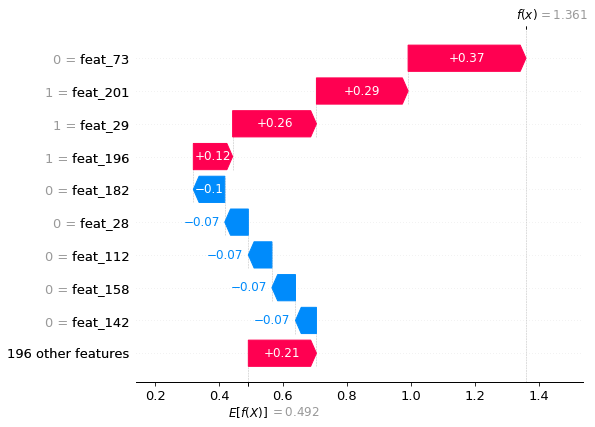

In [12]:
shap_calc.plotSampleExplanation(index=1, plot_type='waterfall')

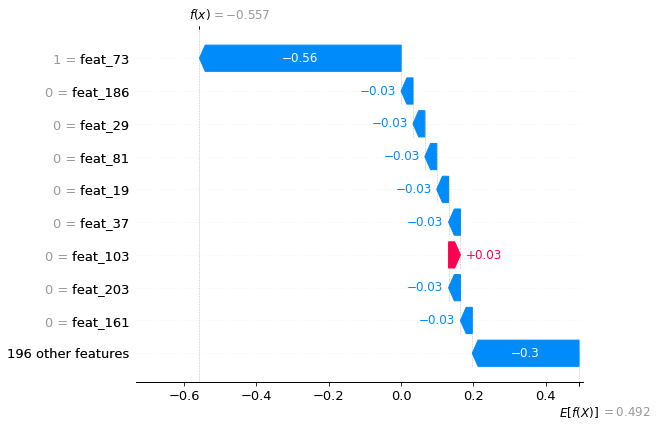

In [13]:
shap_calc.plotSampleExplanation(index=57, plot_type='waterfall')

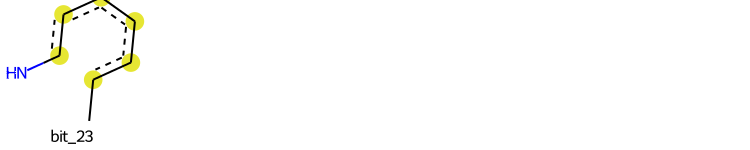

In [14]:
draw_rdk_bits(mole.mols[1], [23])

Bit 23 with 1 hits!


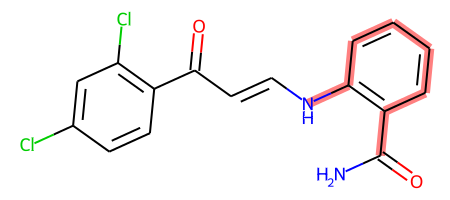

In [15]:
draw_rdk_bit_on_molecule(mole.mols[1], 23)

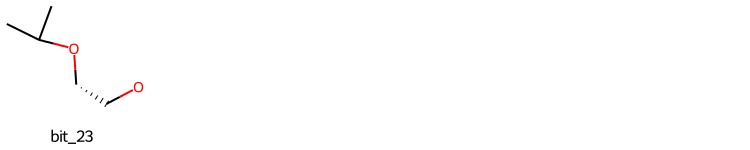

In [16]:
draw_rdk_bits(mole.mols[57], [23])

Bit 23 with 3 hits!


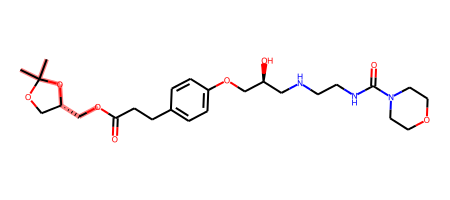

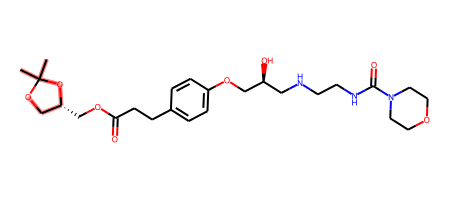

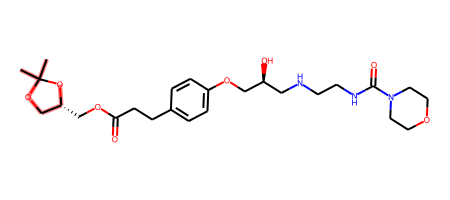

In [17]:
draw_rdk_bit_on_molecule(mole.mols[57], 23)